<H3><b>Fine Tuning VVG16, VGG19, ResNet18, ResNet34 and ResNet50 by adding an Additional linear layer with 256 output features, ReLU activation and Dropout Layer of 50% Probability with the Convolution Layers Frozen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#necessary imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc

In [ ]:
# Define the number of classes in your dataset
num_classes = 2
dropout_prob = 0.5
criterion = nn.CrossEntropyLoss()
num_epochs=10

In [ ]:
#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#path to data folders
train_dir = '/content/drive/MyDrive/Colab Notebooks/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/test'
valid_dir = '/content/drive/MyDrive/Colab Notebooks/valid'

In [ ]:
#defining transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  #resize images to 224x224
        transforms.RandomHorizontalFlip(),  #randomly flip images horizontally
        transforms.ToTensor(),  #convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #normalize images
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
}

In [ ]:
#create DataLoader objects
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
}

In [ ]:
#print dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'valid']}
print("Dataset sizes:", dataset_sizes)

Dataset sizes: {'train': 2536, 'test': 300, 'valid': 100}


<H4><b>Model Training

In [ ]:
# Define function for training a model
def train_model(model, criterion, optimizer, dataloaders, num_epochs):
    model.to(device)
    train_acc_history = []
    valid_acc_history = []

    train_loss_history = []
    valid_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                valid_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                valid_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    return model, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

<h4><b>Model Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))


<h4><B>VGG16

In [ ]:
model_vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze convolutional layers
for param in model_vgg16.features.parameters():
    param.requires_grad = False

# Check the number of input features for the fully connected layer
num_features_vgg16 = model_vgg16.classifier[6].in_features


# Modify the fully connected layers
model_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(num_features_vgg16, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_vgg16 = model_vgg16.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg16.parameters(), lr=0.0001)
torch.cuda.empty_cache()
gc.collect()

8502

In [ ]:
# Train the model
model_vgg16, train_acc_vgg16, valid_acc_vgg16, train_loss_vgg16, valid_loss_vgg16 = train_model(model_vgg16, criterion, optimizer_ft, dataloaders,
                       num_epochs)

Epoch 1/10
----------
train Loss: 0.5444 Acc: 0.7114
valid Loss: 0.5632 Acc: 0.6600
Epoch 2/10
----------
train Loss: 0.4139 Acc: 0.8072
valid Loss: 0.5722 Acc: 0.6900
Epoch 3/10
----------
train Loss: 0.3221 Acc: 0.8675
valid Loss: 0.6587 Acc: 0.6800
Epoch 4/10
----------
train Loss: 0.2644 Acc: 0.8868
valid Loss: 0.4670 Acc: 0.7900
Epoch 5/10
----------
train Loss: 0.1875 Acc: 0.9310
valid Loss: 0.5926 Acc: 0.7700
Epoch 6/10
----------
train Loss: 0.1403 Acc: 0.9468
valid Loss: 0.4820 Acc: 0.8400
Epoch 7/10
----------
train Loss: 0.1414 Acc: 0.9436
valid Loss: 0.5348 Acc: 0.8200
Epoch 8/10
----------
train Loss: 0.0823 Acc: 0.9724
valid Loss: 0.8381 Acc: 0.8200
Epoch 9/10
----------
train Loss: 0.0698 Acc: 0.9736
valid Loss: 0.9472 Acc: 0.7500
Epoch 10/10
----------
train Loss: 0.0583 Acc: 0.9815
valid Loss: 0.7582 Acc: 0.8300


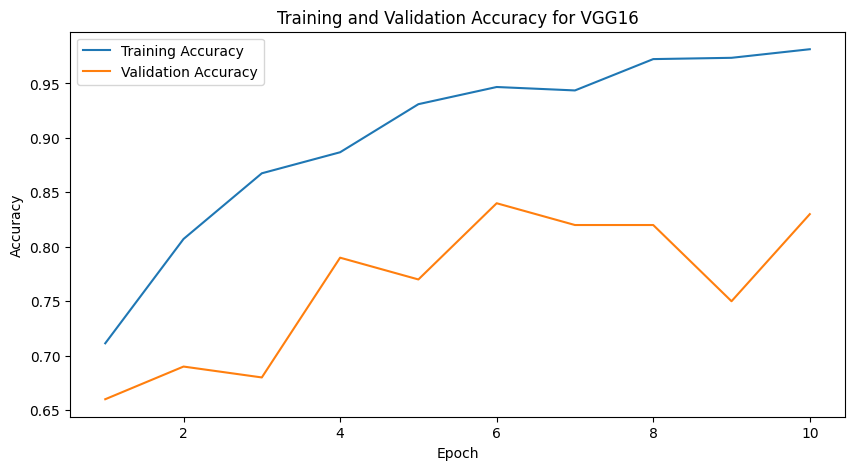

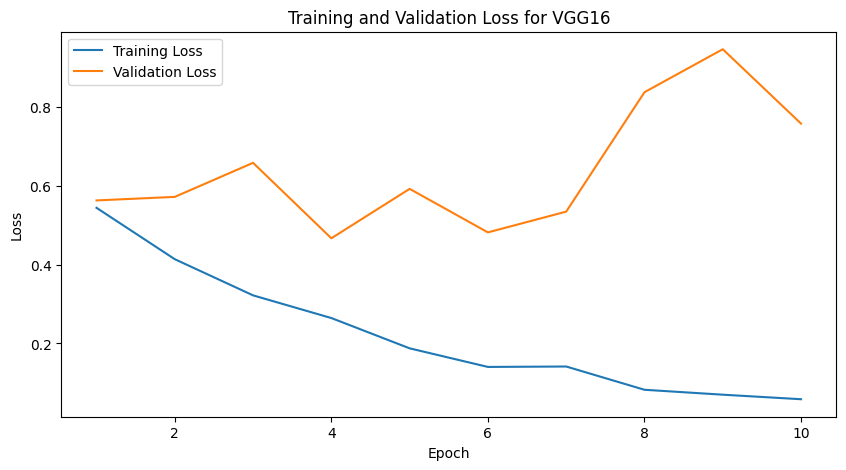

In [ ]:
# Move the accuracies to CPU
train_acc_vgg16_cpu = [acc.cpu().numpy() for acc in train_acc_vgg16]
valid_acc_vgg16_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg16]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg16_cpu) + 1), train_acc_vgg16_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg16_cpu) + 1), valid_acc_vgg16_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg16) + 1), train_loss_vgg16, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg16) + 1), valid_loss_vgg16, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.show()


In [ ]:
print("Evaluating VGG16 on the test set...")
evaluate_model(model_vgg16, dataloaders['test'])

Evaluating VGG16 on the test set...
Accuracy: 0.8233
Precision: 0.8299
Recall: 0.8133
F1-score: 0.8215


<h4><B>VGG19

In [ ]:
model_vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze convolutional layers
for param in model_vgg19.features.parameters():
    param.requires_grad = False

# Check the number of input features for the fully connected layer
num_features_vgg19 = model_vgg19.classifier[6].in_features

# Modify the fully connected layers
model_vgg19.classifier[6] = nn.Sequential(
    nn.Linear(num_features_vgg19, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_vgg19 = model_vgg19.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg19.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7023

In [ ]:
# Train the model
model_vgg19, train_acc_vgg19, valid_acc_vgg19, train_loss_vgg19, valid_loss_vgg19 = train_model(model_vgg19, criterion, optimizer_ft, dataloaders,
                       num_epochs)

Epoch 1/10
----------
train Loss: 0.5364 Acc: 0.7240
valid Loss: 0.6278 Acc: 0.6800
Epoch 2/10
----------
train Loss: 0.4025 Acc: 0.8131
valid Loss: 0.5300 Acc: 0.7400
Epoch 3/10
----------
train Loss: 0.3358 Acc: 0.8517
valid Loss: 0.6456 Acc: 0.7400
Epoch 4/10
----------
train Loss: 0.2645 Acc: 0.8868
valid Loss: 0.6574 Acc: 0.7300
Epoch 5/10
----------
train Loss: 0.2380 Acc: 0.8955
valid Loss: 0.5743 Acc: 0.7800
Epoch 6/10
----------
train Loss: 0.1951 Acc: 0.9196
valid Loss: 0.7217 Acc: 0.7400
Epoch 7/10
----------
train Loss: 0.1347 Acc: 0.9472
valid Loss: 0.6619 Acc: 0.7200
Epoch 8/10
----------
train Loss: 0.1181 Acc: 0.9590
valid Loss: 0.6661 Acc: 0.7800
Epoch 9/10
----------
train Loss: 0.0991 Acc: 0.9657
valid Loss: 0.7376 Acc: 0.8000
Epoch 10/10
----------
train Loss: 0.0841 Acc: 0.9712
valid Loss: 0.8094 Acc: 0.7800


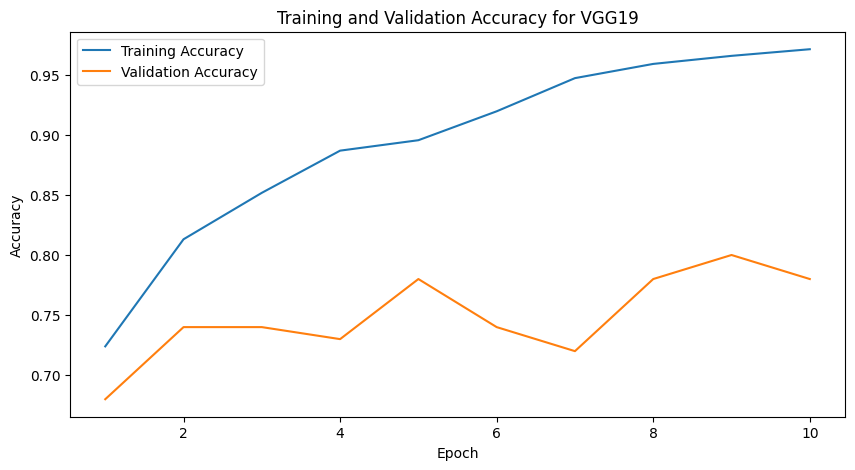

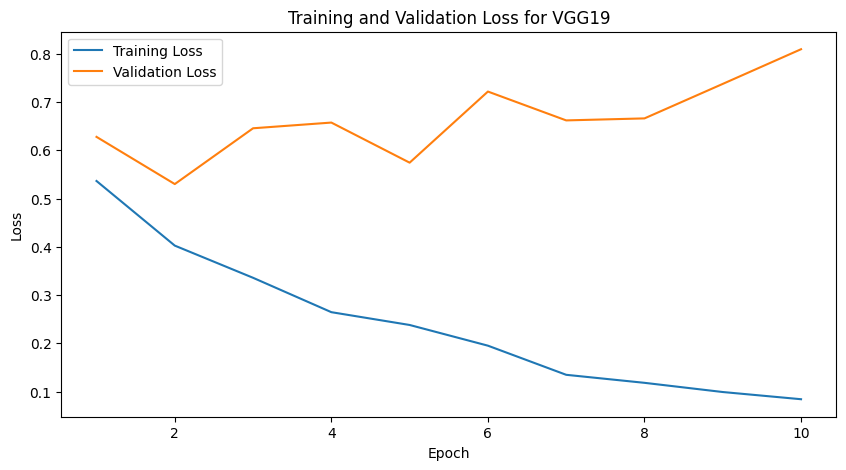

In [ ]:
# Move the accuracies to CPU
train_acc_vgg19_cpu = [acc.cpu().numpy() for acc in train_acc_vgg19]
valid_acc_vgg19_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg19]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg19_cpu) + 1), train_acc_vgg19_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg19_cpu) + 1), valid_acc_vgg19_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG19')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg19) + 1), train_loss_vgg19, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg19) + 1), valid_loss_vgg19, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG19')
plt.legend()
plt.show()


In [ ]:
print("Evaluating VGG19 on the test set...")
evaluate_model(model_vgg19, dataloaders['test'])

Evaluating VGG19 on the test set...
Accuracy: 0.8200
Precision: 0.8077
Recall: 0.8400
F1-score: 0.8235


<h4><b>ResNet18

In [ ]:
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze convolutional layers
for name, param in model_resnet18.named_parameters():
    if 'fc' not in name:  # Skip parameters of the fully connected layer
        param.requires_grad = False
# Modify the model head for fine-tuning
num_features_resnet18 = model_resnet18.fc.in_features


# Additional linear layer and dropout layer
model_resnet18.fc = nn.Sequential(
    nn.Linear(num_features_resnet18, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)


model_resnet18 = model_resnet18.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7341

In [ ]:
# Train the model
model_resnet18, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model_resnet18, criterion, optimizer_ft, dataloaders,
                       num_epochs)

Epoch 1/10
----------
train Loss: 0.6533 Acc: 0.6073
valid Loss: 0.5896 Acc: 0.7100
Epoch 2/10
----------
train Loss: 0.5888 Acc: 0.6979
valid Loss: 0.5693 Acc: 0.7300
Epoch 3/10
----------
train Loss: 0.5427 Acc: 0.7287
valid Loss: 0.5339 Acc: 0.7100
Epoch 4/10
----------
train Loss: 0.5264 Acc: 0.7394
valid Loss: 0.5235 Acc: 0.7100
Epoch 5/10
----------
train Loss: 0.4988 Acc: 0.7646
valid Loss: 0.5149 Acc: 0.7600
Epoch 6/10
----------
train Loss: 0.4915 Acc: 0.7642
valid Loss: 0.5050 Acc: 0.7600
Epoch 7/10
----------
train Loss: 0.4811 Acc: 0.7717
valid Loss: 0.5114 Acc: 0.7700
Epoch 8/10
----------
train Loss: 0.4693 Acc: 0.7808
valid Loss: 0.5490 Acc: 0.7200
Epoch 9/10
----------
train Loss: 0.4663 Acc: 0.7772
valid Loss: 0.5095 Acc: 0.7600
Epoch 10/10
----------
train Loss: 0.4638 Acc: 0.7737
valid Loss: 0.4925 Acc: 0.7600


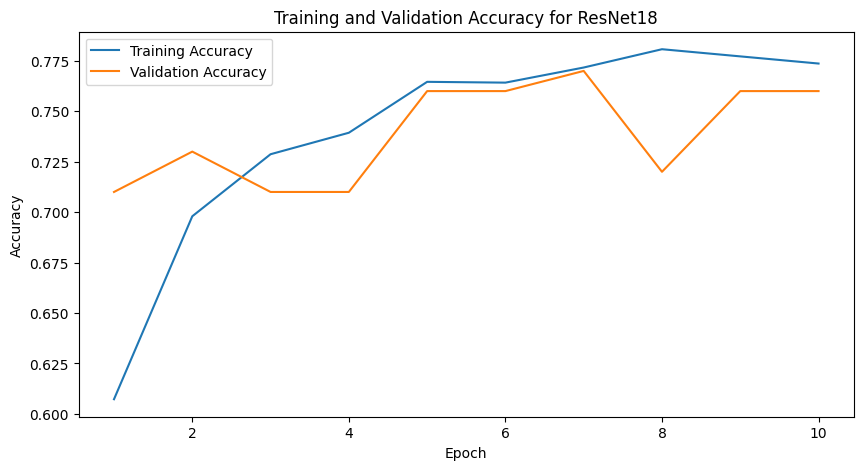

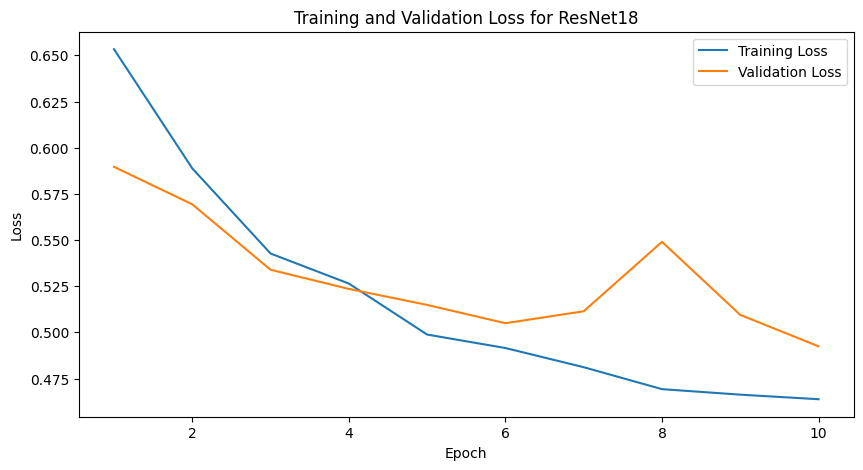

In [ ]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18')
plt.legend()
plt.show()


In [ ]:
print("Evaluating ResNet18 on the test set...")
evaluate_model(model_resnet18, dataloaders['test'])

Evaluating ResNet18 on the test set...
Accuracy: 0.7967
Precision: 0.8296
Recall: 0.7467
F1-score: 0.7860


<h4><b>ResNet34

In [ ]:
model_resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze convolutional layers
for name, param in model_resnet34.named_parameters():
    if 'fc' not in name:  # Skip parameters of the fully connected layer
        param.requires_grad = False
# Modify the model head for fine-tuning
num_features_resnet34 = model_resnet34.fc.in_features


# Additional linear layer and dropout layer
model_resnet34.fc = nn.Sequential(
    nn.Linear(num_features_resnet34, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_resnet34 = model_resnet34.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7527

In [ ]:
# Train the model
model_resnet34, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model_resnet34, criterion, optimizer_ft, dataloaders,
                       num_epochs)

Epoch 1/10
----------
train Loss: 0.6573 Acc: 0.6013
valid Loss: 0.6022 Acc: 0.6800
Epoch 2/10
----------
train Loss: 0.5778 Acc: 0.6968
valid Loss: 0.5472 Acc: 0.7300
Epoch 3/10
----------
train Loss: 0.5456 Acc: 0.7295
valid Loss: 0.5340 Acc: 0.7200
Epoch 4/10
----------
train Loss: 0.5261 Acc: 0.7370
valid Loss: 0.5154 Acc: 0.7400
Epoch 5/10
----------
train Loss: 0.5092 Acc: 0.7401
valid Loss: 0.5061 Acc: 0.7400
Epoch 6/10
----------
train Loss: 0.5003 Acc: 0.7445
valid Loss: 0.5238 Acc: 0.7400
Epoch 7/10
----------
train Loss: 0.4847 Acc: 0.7681
valid Loss: 0.5163 Acc: 0.7400
Epoch 8/10
----------
train Loss: 0.4742 Acc: 0.7642
valid Loss: 0.5119 Acc: 0.7400
Epoch 9/10
----------
train Loss: 0.4729 Acc: 0.7693
valid Loss: 0.5041 Acc: 0.7400
Epoch 10/10
----------
train Loss: 0.4659 Acc: 0.7831
valid Loss: 0.5077 Acc: 0.7300


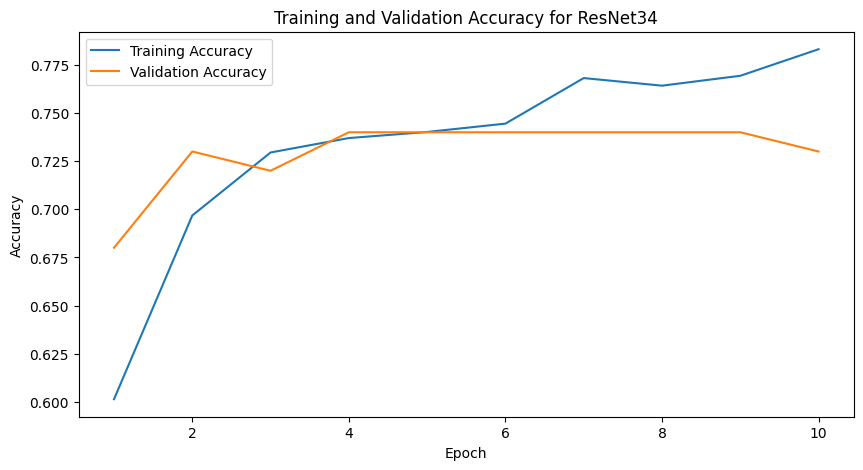

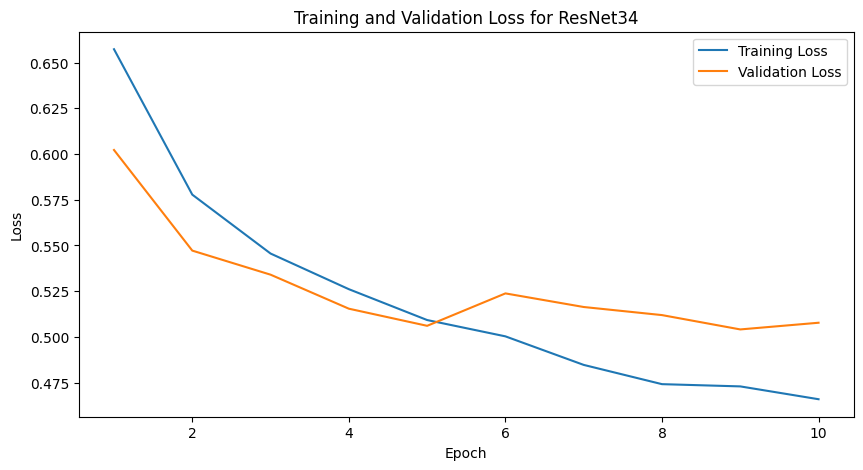

In [ ]:
 # Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34')
plt.legend()
plt.show()

In [ ]:
print("Evaluating RestNet34 on the test set...")
evaluate_model(model_resnet34, dataloaders['test'])

Evaluating RestNet34 on the test set...
Accuracy: 0.8200
Precision: 0.8077
Recall: 0.8400
F1-score: 0.8235


<h4><b>ResNet50

In [ ]:
model_resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze convolutional layers
for name, param in model_resnet50.named_parameters():
    if 'fc' not in name:  # Skip parameters of the fully connected layer
        param.requires_grad = False
# Modify the model head for fine-tuning
num_features_resnet50 = model_resnet50.fc.in_features

# Additional linear layer and dropout layer
model_resnet50.fc = nn.Sequential(
    nn.Linear(num_features_resnet50, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)


model_resnet50 = model_resnet50.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7527

In [ ]:
# Train the model
model_resnet50, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model_resnet50, criterion, optimizer_ft, dataloaders,
                       num_epochs)

Epoch 1/10
----------
train Loss: 0.6429 Acc: 0.6199
valid Loss: 0.5980 Acc: 0.7100
Epoch 2/10
----------
train Loss: 0.5465 Acc: 0.7421
valid Loss: 0.5460 Acc: 0.7300
Epoch 3/10
----------
train Loss: 0.5085 Acc: 0.7449
valid Loss: 0.5198 Acc: 0.7600
Epoch 4/10
----------
train Loss: 0.4895 Acc: 0.7697
valid Loss: 0.5678 Acc: 0.7400
Epoch 5/10
----------
train Loss: 0.4888 Acc: 0.7701
valid Loss: 0.5065 Acc: 0.7600
Epoch 6/10
----------
train Loss: 0.4762 Acc: 0.7780
valid Loss: 0.5368 Acc: 0.7200
Epoch 7/10
----------
train Loss: 0.4689 Acc: 0.7744
valid Loss: 0.6021 Acc: 0.7100
Epoch 8/10
----------
train Loss: 0.4613 Acc: 0.7827
valid Loss: 0.5085 Acc: 0.7400
Epoch 9/10
----------
train Loss: 0.4526 Acc: 0.7863
valid Loss: 0.4890 Acc: 0.7600
Epoch 10/10
----------
train Loss: 0.4529 Acc: 0.7819
valid Loss: 0.4933 Acc: 0.7400


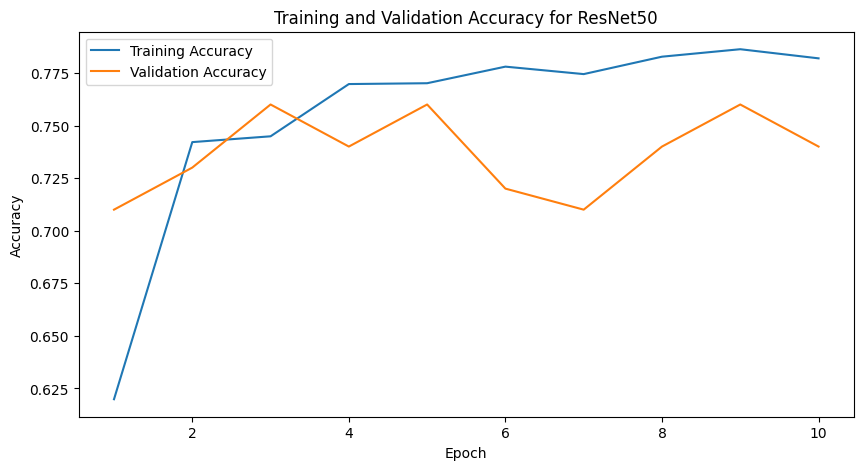

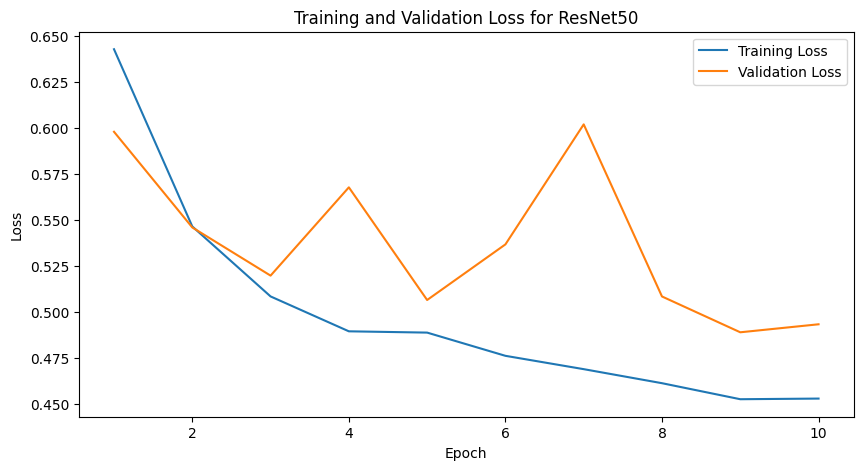

In [ ]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50')
plt.legend()
plt.show()


In [ ]:
print("Evaluating ResNet50 on the test set...")
evaluate_model(model_resnet50, dataloaders['test'])

Evaluating ResNet50 on the test set...
Accuracy: 0.8267
Precision: 0.8551
Recall: 0.7867
F1-score: 0.8194
